In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torchvision
import datasets
from datasets import load_dataset

import nevergrad as ng

import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import copy
import os
from tqdm import tqdm

import sys
sys.path.append("../")
sys.path.append("nevergrad/")
from ucimlrepo import fetch_ucirepo 
from models import CNN_Simple,All_CNN_C,VAE,LSTM

/Users/m/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
os.environ["WANDB_DISABLED"] = "true"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
print(device)

cpu


In [3]:
class TrainManager:
    def __init__(self, model, dataloader_train, dataloader_test, loss, device, isLSTM=False):
        self.device = device
        self.model = model.to(self.device)
        self.best_model = None
        self.dataloader_train = dataloader_train
        self.dataloader_test = dataloader_test
        self.best_score = 1e9
        self.loss = loss
        self.epoch = 1
        self.n_samples = len(dataloader_train)
        self.iteration = 0
        self.test_losses = []
        self.train_losses = []
        # self.best_output = []
        # self.LSTM = isLSTM
            
    def evaluate(self, model):
        # Assume that test loader contains only one batch
        test_inputs, test_labels = next(iter(self.dataloader_test))
        predicted = model(test_inputs)
        
        # Compute loss
        loss = self.loss(predicted, test_labels.flatten())

        predicted_labels = torch.argmax(predicted, axis=1)
        accuracy = torch.sum(test_labels.flatten() == predicted_labels) / len(predicted)
        
        return loss.item(), accuracy


    def cost_function(self, parameters):
        load_params(self.model, torch.tensor(parameters))
        
        # Load the next batch
        inputs, labels = next(iter(self.dataloader_train))
        
        predicted = self.model(inputs).to(device)
        loss = self.loss(predicted, labels.flatten()).item()

        test_loss, accuracy = self.evaluate(self.model)
        if self.best_score > test_loss :
            self.best_score = test_loss
            self.best_model = copy.deepcopy(self.model)

        print(f'epoch {self.epoch}; test loss function : {test_loss}, accuracy: {accuracy:.2f} best score : {self.best_score}')
        
        self.iteration += 1

        self.test_losses.append(test_loss)
        self.train_losses.append(loss)

        if self.iteration % self.n_samples == 0: 
            self.epoch += 1

        return loss

In [4]:
def load_params(model, param_tensor):
    current_index = 0
    for param in model.parameters():
        param_length = param.numel()
        param.data = param_tensor[current_index:current_index + param_length].reshape(param.size()).to(device)
        current_index += param_length


P0 : wine (small model)

In [10]:
# create model
class Net(nn.Module):
    def __init__(self, n_classes: int):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(11, 32).to(dtype=torch.double)
        self.relu1 = nn.GELU()
        self.fc2 = nn.Linear(32, 32).to(dtype=torch.double)
        self.relu2 = nn.GELU()
        self.fc3 = nn.Linear(32, n_classes)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.softmax(x)

        return x

class create_dataset(Dataset):
    def __init__(self, data, data_classes):
        self.data = data
        self.data_classes = data_classes
        
    def __getitem__(self, index):
        x = torch.from_numpy(self.data.iloc[index][:-1].to_numpy())
        
        label = self.data.iloc[index][-1:].to_numpy()[0]
        y = np.where(data_classes == label)[0]
        
        return x, y
    
    def __len__(self):
        return len(self.data)
    
# data = pd.read_csv("data/winequality-red.csv", sep=";")

wine_quality  = fetch_ucirepo(id=186)
data_inputs = wine_quality.data.features
data_outputs = wine_quality.data.targets

data = pd.concat([data_inputs, data_outputs], axis=1)

data_train, data_test = train_test_split(data, test_size=0.25)
# normalize data
scaler = StandardScaler()
columns_to_normalize = data_train.columns[data_train.columns != "quality"].tolist()
data_train[columns_to_normalize] = scaler.fit_transform(data_train[columns_to_normalize])
data_test[columns_to_normalize] = scaler.transform(data_test[columns_to_normalize])

data_classes = np.sort(data["quality"].unique())

dataset_train = create_dataset(data_train, data_classes)
dataset_test  = create_dataset(data_test, data_classes)
training_loader = DataLoader(dataset_train, batch_size=len(data_train), shuffle=True)
validation_loader = DataLoader(dataset_test, batch_size=len(data_test), shuffle=True)

In [11]:
def compute_loss_weights(data_train_quality, data_classes):
    count = np.zeros(data_classes.shape)

    for label in data_train_quality:
        y = np.where(data_classes == label)[0]
        count[y] += 1
    
    weights = 1 / count
    weights = weights / np.sum(weights)
    return weights

In [12]:
print(data_classes)

[3 4 5 6 7 8 9]


In [8]:
# model = Net().to(device)
# trainer = TrainManager(model, training_loader, validation_loader, loss, device)
# plt.hist(next(iter(trainer.model.parameters())).flatten().detach().numpy())

In [13]:
model = Net(len(data_classes)).to(device)
#model.load_state_dict(torch.load('models/Net.pt'))

# loss_weights = compute_loss_weights(data_train["quality"], data_classes)
loss = nn.CrossEntropyLoss()

epochs = 500
nb_batch = len(training_loader)
trainer = TrainManager(model, training_loader, validation_loader, loss, device)
fitness = trainer.cost_function

# Compute number of parameters of the model + initialize parametrization
init_params = torch.concatenate([p.data.flatten() for p in trainer.model.parameters()])
parametrization = ng.p.Array(init=init_params)
optimizer = ng.optimizers.NGOpt(parametrization=parametrization, budget=epochs*nb_batch, num_workers=1)
optimizer.a = 1e1
learned_param = optimizer.minimize(fitness)

/Users/m/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


epoch 1; test loss function : 1.9414846042967717, accuracy: 0.11 best score : 1.9414846042967717
epoch 2; test loss function : 2.10773654436912, accuracy: 0.06 best score : 1.9414846042967717
epoch 3; test loss function : 2.109324922622008, accuracy: 0.06 best score : 1.9414846042967717
epoch 4; test loss function : 1.716237526312477, accuracy: 0.45 best score : 1.716237526312477
epoch 5; test loss function : 1.8926878417972268, accuracy: 0.27 best score : 1.716237526312477
epoch 6; test loss function : 1.893933999448525, accuracy: 0.27 best score : 1.716237526312477
epoch 7; test loss function : 1.8586020491767525, accuracy: 0.31 best score : 1.716237526312477
epoch 8; test loss function : 1.9002122596671993, accuracy: 0.26 best score : 1.716237526312477
epoch 9; test loss function : 1.7661044627394766, accuracy: 0.40 best score : 1.716237526312477
epoch 10; test loss function : 1.900208493623283, accuracy: 0.27 best score : 1.716237526312477
epoch 11; test loss function : 1.756928746

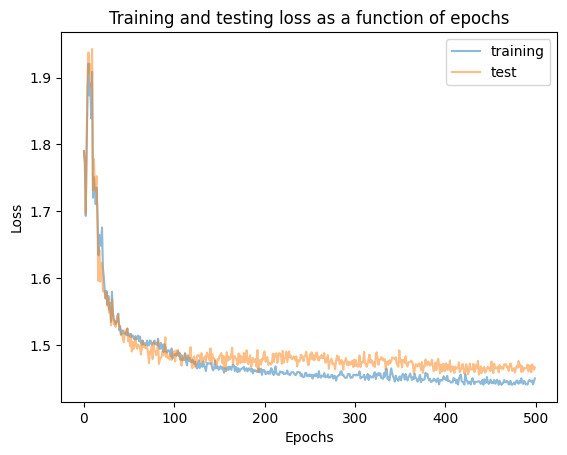

In [ ]:
loss = []

# epochs_space = np.linspace(0, epochs, len(trainer.train_losses))

plt.plot(trainer.train_losses, label="training", alpha=0.5)
plt.plot(trainer.test_losses, label="test", alpha=0.5)
plt.ylabel('Loss')
plt.xlabel('Epochs')
# plt.yscale("log")
plt.title("Training and testing loss as a function of epochs")
plt.legend()
plt.show()

In [ ]:
test_inputs, test_labels = next(iter(validation_loader))
predicted = trainer.best_model(test_inputs)
predicted_labels = torch.argmax(predicted, axis=1)

print(predicted_labels)
print(test_labels.flatten())

tensor([2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2,
        2, 2, 3, 2, 3, 3, 2, 2, 2, 3, 3, 2, 3, 2, 2, 3, 3, 2, 3, 2, 2, 3, 2, 3,
        3, 2, 3, 3, 2, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2, 3,
        3, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 2, 3, 2, 3, 2, 3, 3, 2, 2, 2,
        2, 2, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 3, 3,
        3, 2, 2, 2, 2, 3, 3, 2, 3, 2, 3, 2, 3, 3, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3,
        2, 2, 3, 2, 3, 2, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 3, 3, 2, 3, 3, 3,
        2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 3, 2, 3, 2,
        3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2,
        3, 2, 2, 2, 2, 3, 2, 3, 2, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2, 3, 2, 3, 3,
        2, 3, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 2, 3, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2,
        2, 3, 2, 3, 3, 2, 2, 3, 3, 3, 2,

P1

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(lambda x: x.double()),
    transforms.Normalize((0.5,), (0.5,))])
training_set = torchvision.datasets.FashionMNIST("./data", train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST("./data", train=False, transform=transform, download=True)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=len(training_set)//1, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=len(validation_set)//1, shuffle=False)

In [ ]:
model = CNN_Simple().to(device)
torch.save(model.state_dict(), 'models/CNN_Simple.pt')
loss = nn.CrossEntropyLoss()

restart here for another optimizer

In [ ]:
model.load_state_dict(torch.load('models/CNN_Simple.pt'))

epochs = 20
nb_batch = len(training_loader)
trainer = TrainManager(model,training_loader,validation_loader,loss,device)
fitness = trainer.cost_function

# Compute number of parameters of the model + initialize parametrization
num_params = sum(p.numel() for p in model.parameters())
parametrization = ng.p.Array(shape=(num_params,))
optimizer = ng.optimizers.SPSA(parametrization=parametrization, budget=epochs*nb_batch)
optimizer.a = 0.1

In [ ]:
learned_param = optimizer.minimize(fitness)

epoch 1; test loss function : 2.3175029025740232, accuracy: 0.15 best score : 2.3175029025740232
epoch 2; test loss function : 2.364321473869504, accuracy: 0.07 best score : 2.3175029025740232
epoch 3; test loss function : 2.333791558217982, accuracy: 0.12 best score : 2.3175029025740232
epoch 4; test loss function : 2.3300066381417928, accuracy: 0.08 best score : 2.3175029025740232
epoch 5; test loss function : 2.3006862549049676, accuracy: 0.08 best score : 2.3006862549049676
epoch 6; test loss function : 2.3351243512697883, accuracy: 0.06 best score : 2.3006862549049676
epoch 7; test loss function : 2.338040919250822, accuracy: 0.10 best score : 2.3006862549049676
epoch 8; test loss function : 2.344324293833923, accuracy: 0.10 best score : 2.3006862549049676
epoch 9; test loss function : 2.3500147583640967, accuracy: 0.08 best score : 2.3006862549049676
epoch 10; test loss function : 2.3193724217370755, accuracy: 0.08 best score : 2.3006862549049676
epoch 11; test loss function : 2.